<a href="https://colab.research.google.com/github/dokin0802/SinGAN/blob/master/jeh5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
path = '/content/drive/MyDrive/architecture_aug/org/g'
g = glob.glob(path+'/*')

def rename(files):
  for i,f in enumerate(files):
      os.rename(f, os.path.join(path, 'g_' + '{0:03d}.jpg'.format(i)))

In [4]:
rename(g)


In [2]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
dir_ = Path('/content/drive/MyDrive/architecture_aug/ex3')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/architecture_aug/ex3/va...,r
1,/content/drive/MyDrive/architecture_aug/ex3/tr...,g
2,/content/drive/MyDrive/architecture_aug/ex3/tr...,g
3,/content/drive/MyDrive/architecture_aug/ex3/tr...,r
4,/content/drive/MyDrive/architecture_aug/ex3/tr...,r


In [5]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 499

Number of different labels: 2

Labels: ['r' 'g']


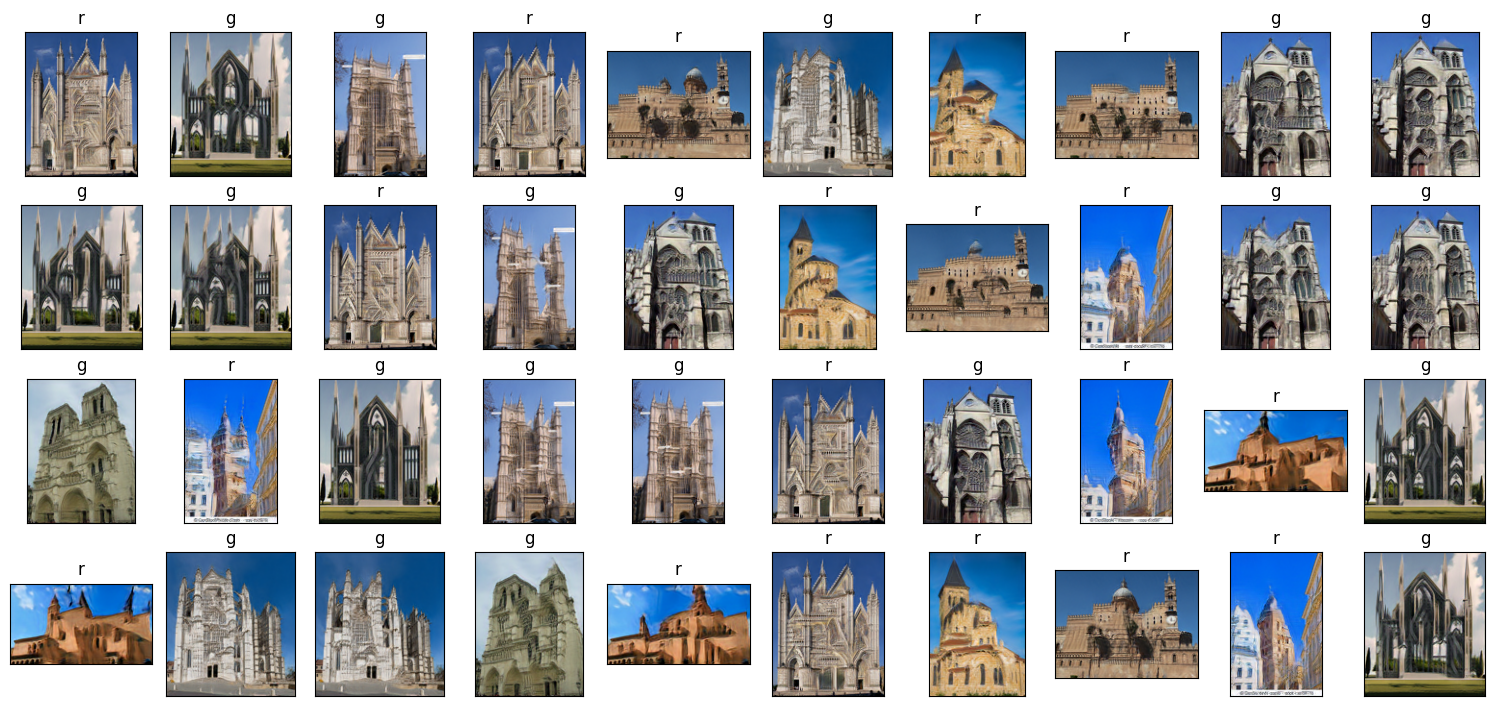

In [6]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

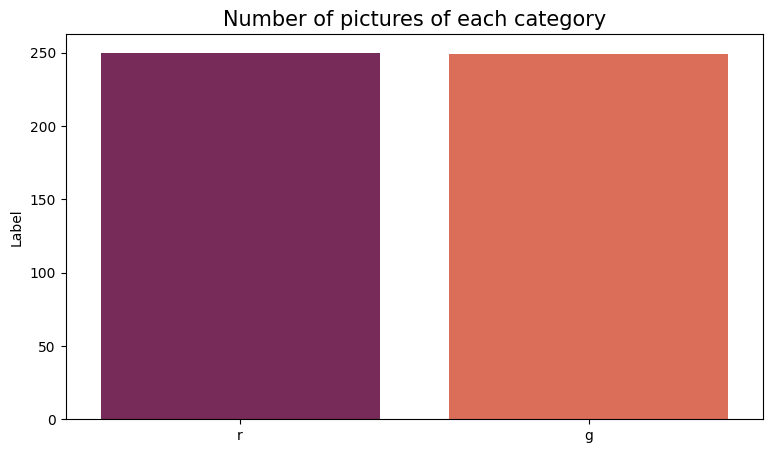

In [7]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [8]:
train_df =df

dir_ = Path('/content/drive/MyDrive/architecture_small/test')
filepaths = list(dir_.glob(r'**/*.jpg'))
test_df = proc_img(filepaths)

In [9]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.20)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/architecture_aug/ex3',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'binary',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/drive/MyDrive/architecture_aug/ex3',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'binary',subset='validation')

Found 400 images belonging to 2 classes.
Found 99 images belonging to 2 classes.


In [10]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'binary_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [11]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
13/13 [==============================] - 179s 13s/step - loss: 0.8842 - accuracy: 0.7400 - val_loss: 0.5158 - val_accuracy: 0.7980
Epoch 2/10
13/13 [==============================] - 1s 95ms/step - loss: 0.5090 - accuracy: 0.8000 - val_loss: 0.5359 - val_accuracy: 0.7980
Epoch 3/10
13/13 [==============================] - 1s 94ms/step - loss: 0.5018 - accuracy: 0.8000 - val_loss: 0.5473 - val_accuracy: 0.7980
Epoch 4/10
13/13 [==============================] - 1s 98ms/step - loss: 0.4715 - accuracy: 0.8025 - val_loss: 0.6578 - val_accuracy: 0.6263
Epoch 5/10
13/13 [==============================] - 1s 98ms/step - loss: 0.4494 - accuracy: 0.7975 - val_loss: 0.6928 - val_accuracy: 0.5556
Epoch 6/10
13/13 [==============================] - 1s 94ms/step - loss: 0.4104 - accuracy: 0.8325 - val_loss: 0.7942 - val_accuracy: 0.4646
Epoch 7/10
13/13 [==============================] - 1s 97ms/step - loss: 0.4176 - accuracy: 0.8425 - val_loss: 0.6834 - val_accuracy: 0.5556
Epoch 8/10
1

In [12]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [13]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 450 validated image filenames belonging to 2 classes.
Found 49 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


29084464/29084464 [==============================] - 3s 0us/step
DenseNet121          trained in 10.83 sec
9406464/9406464 [==============================] - 1s 0us/step
MobileNetV2          trained in 5.87 sec
74836368/74836368 [==============================] - 4s 0us/step
DenseNet201          trained in 15.93 sec
16705208/16705208 [==============================] - 2s 0us/step


EfficientNetB0       trained in 10.29 sec
27018416/27018416 [==============================] - 2s 0us/step


EfficientNetB1       trained in 13.81 sec
87910968/87910968 [==============================] - 5s 0us/step
InceptionV3          trained in 9.29 sec
12683000/12683000 [==============================] - 2s 0us/step
MobileNetV3Large     trained in 7.77 sec
234545216/234545216 [==============================] - 11s 0us/step
ResNet152V2          trained in 13.87 sec
94765736/94765736 [==============================] - 5s 0us/step
ResNet50             trained in 7.14 sec
94668760/94668760 [==============================] - 5s 0us/step
ResNet50V2           trained in 6.34 sec
80134624/80134624 [==============================] - 4s 0us/step
VGG19                trained in 5.89 sec
58889256/58889256 [==============================] - 4s 0us/step
VGG16                trained in 3.49 sec
83683744/83683744 [==============================] - 4s 0us/step
Xception             trained in 6.17 sec


In [14]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

4/4 [==============================] - 44s 14s/step
**DenseNet121 has a 50.00% accuracy on the test set**
4/4 [==============================] - 3s 424ms/step
**MobileNetV2 has a 50.00% accuracy on the test set**
4/4 [==============================] - 5s 430ms/step
**DenseNet201 has a 50.00% accuracy on the test set**
4/4 [==============================] - 3s 429ms/step
**EfficientNetB0 has a 50.00% accuracy on the test set**
4/4 [==============================] - 4s 424ms/step
**EfficientNetB1 has a 50.00% accuracy on the test set**
4/4 [==============================] - 4s 564ms/step
**InceptionV3 has a 50.00% accuracy on the test set**
4/4 [==============================] - 3s 424ms/step
**MobileNetV3Large has a 50.00% accuracy on the test set**
4/4 [==============================] - 4s 466ms/step
**ResNet152V2 has a 50.00% accuracy on the test set**
4/4 [==============================] - 3s 493ms/step
**ResNet50 has a 50.00% accuracy on the test set**
4/4 [=========================

,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet121,0.5,0.5,10.83
1,MobileNetV2,0.5,0.5,5.87
2,DenseNet201,0.5,0.5,15.93
3,EfficientNetB0,0.5,0.5,10.29
4,EfficientNetB1,0.5,0.5,13.81
5,InceptionV3,0.5,0.5,9.29
6,MobileNetV3Large,0.5,0.5,7.77
7,ResNet152V2,0.5,0.5,13.87
8,ResNet50,0.5,0.5,7.14
9,ResNet50V2,0.5,0.5,6.34


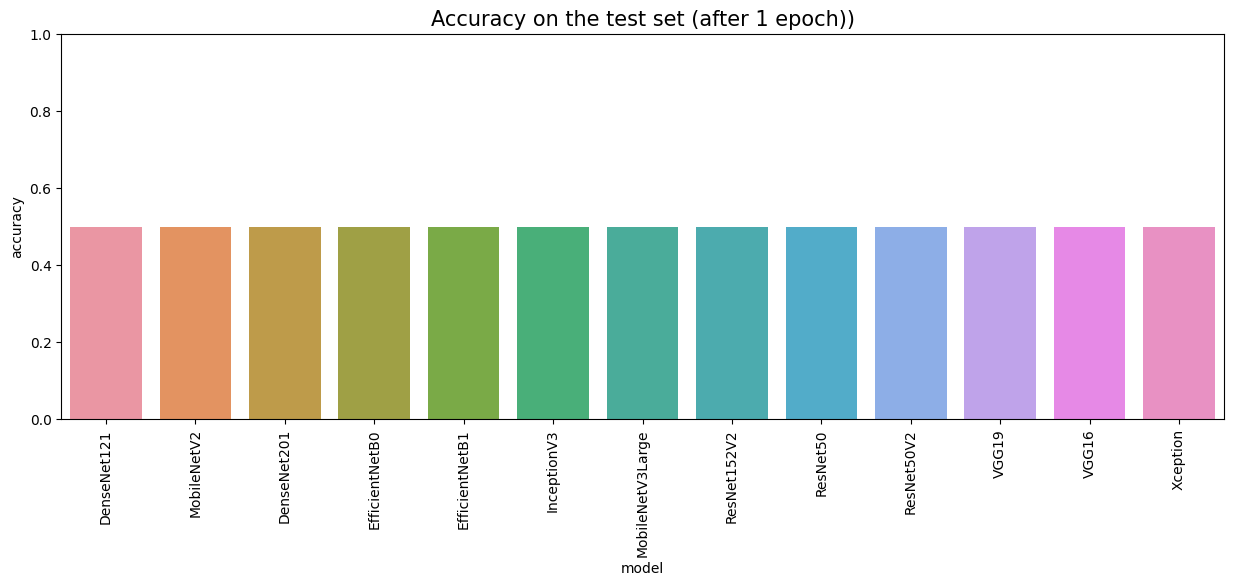

In [15]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()